# prepare

In [1]:
DAYS_BEFORE = 300

In [2]:
# import necessaries
import tushare as ts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
import tushare as ts
from datetime import datetime, timedelta
import time
from scipy import stats
pro = ts.pro_api()
pd.set_option('display.max_rows', 1000)



# ignore warning
import warnings
warnings.filterwarnings("ignore")

# def draw_pic(data, title_name):
#     plt.figure(figsize=(12,8))
#     plt.plot(data)
#     plt.title(title_name)
#     plt.show()


def get_option_info(key_words_list):
    temp = pro.opt_basic(
        exchange='SSE',
        call_put='C',
        fields=
        'ts_code,name,exercise_price, list_date,delist_date,maturity_date')
    for i in key_words_list:
        temp = temp[temp['name'].str.contains(i)]
    return temp


def get_opiton_code(key_words_list):
    return str(get_option_info(key_words_list)['ts_code'].values[0])


def get_date_info(option_info):
    begin_date = str(option_info['list_date'].values[0])
    end_date = str(option_info['delist_date'].values[0])
    before_begin_date = datetime.strftime(
        datetime.strptime(begin_date, '%Y%m%d') - timedelta(days=DAYS_BEFORE),
        '%Y%m%d')
    return begin_date, end_date, before_begin_date


def col_to_date_and_as_index(df, col_name):
    df[col_name] = pd.to_datetime(df[col_name])
    df.index = df[col_name]


def get_option_trade_data(option_code):
    pro = ts.pro_api()
    option_trade = pro.opt_daily(ts_code=option_code)
    col_to_date_and_as_index(option_trade, 'trade_date')
    return option_trade.sort_index()


def get_underlying_asset_trade_data():
    pro = ts.pro_api()
    data = pro.fund_daily(
        ts_code='510050.SH', start_date=before_begin_date, end_date=end_date)
    col_to_date_and_as_index(data, 'trade_date')
    return data.sort_index()


def history_volatility(price_series, periods):
    volatility = pd.DataFrame(index=price_series.index)
    volatility['log_return'] = np.log(price_series) - np.log(
        price_series).shift(1)
    volatility['std'] = price_series.rolling(window=periods).std(
        ddof=1) * np.sqrt(250) / np.sqrt(periods)
    return volatility['std']


def get_risk_free_rate_data():
    #pro = ts.pro_api()
    df = pro.shibor(
        start_date=begin_date, end_date=end_date, fields='date,3m,1y')
    df['ccr'] = np.log(1 + df['1y'] / 100)
    col_to_date_and_as_index(df, 'date')
    return df


def d1(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def d2(S0, K, r, sigma, T, q=0):
    if q!=0:
        print("q=",q)
    return (np.log(S0 / K) + (r -q - sigma**2 / 2) * T) / (sigma * np.sqrt(T))


def BlackScholes(type, S0, K, r, sigma, T, q=0):
    """
    S0  stock price
    K   strike price
    r   continuously compounded risk-free rate:
    sigma   volatility of the stock price per year
    T   time to maturity in trading years

    """
    if q!=0:
        print("q=",q)
    if type == "C":
        return S0 * ss.norm.cdf(d1(S0, K, r, sigma, T,q)) - K * np.exp(
            -r * T) * ss.norm.cdf(d2(S0, K, r, sigma, T,q))
    else:
        return K * np.exp(-r * T) * ss.norm.cdf(-d2(
            S0, K, r, sigma, T,q=0)) - S0 * ss.norm.cdf(-d1(S0, K, r, sigma, T,q=0))
   




# set plot conf
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def construct_BS_summary_table(key_words, div=0):
    """
    key_words - list: key words of option
    volatility - Pandas series: sigma of the underlying asset trade data
    """
    global begin_date, end_date, before_begin_date, option_code, k
    option_info = get_option_info(key_words)
    option_code = get_opiton_code(key_words)
    begin_date, end_date, before_begin_date = get_date_info(option_info)
    option_trade = get_option_trade_data(option_code)
    underlying_asset_trade = get_underlying_asset_trade_data()
    risk_free_rate = get_risk_free_rate_data()

    k = option_info['exercise_price'].values[0]
    summary = pd.DataFrame(index=option_trade.index)
    summary['s'] = underlying_asset_trade['close']
    summary['t'] = (
        datetime.strptime(option_info['maturity_date'].values[0], "%Y%m%d") -
        underlying_asset_trade['trade_date']).dt.days / 365.0
    summary['r'] = risk_free_rate['ccr']
    summary['sigma'] = history_volatility(underlying_asset_trade['close'], 90) 
    #
    summary['bs_simulate'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'], q=div)
    summary['real_price'] = option_trade['close']
    summary = summary.dropna()
    print("Mean_Absolute_Percentage_Error: ", mean_absolute_percentage_error(summary['bs_simulate'], summary['real_price']))
    
    return summary

# Divident info

In [4]:
div_tab = pro.fund_div(ts_code = '510050.SH')

In [5]:
div_tab

,ts_code,ann_date,imp_anndate,base_date,div_proc,record_date,ex_date,pay_date,earpay_date,net_ex_date,div_cash,base_unit,ear_distr,ear_amount,account_date,base_year
0,510050.SH,20161111,20161111,20161031,实施,20161128,20161129,20161202,None,20161129,0.053,1.229017e+06,1.780059e+10,6.513788e+08,None,20161128
1,510050.SH,20101110,20101110,20101031,实施,20101115,20101116,20101119,None,20101116,0.026,1.254157e+06,3.289532e+08,NaN,None,20101029
2,510050.SH,20121107,20121107,20121031,实施,20121112,20121113,20121116,None,20121113,0.037,1.121215e+06,8.581111e+09,4.148495e+08,None,20121112
3,510050.SH,20081114,20081114,20081031,实施,20081118,20081119,20081124,None,20081119,0.060,1.125857e+06,6.669069e+08,NaN,None,20080930
4,510050.SH,20120510,20120510,20120430,实施,20120515,20120516,20120521,None,20120516,0.011,1.188838e+06,1.153437e+10,1.307722e+08,None,20120515
5,510050.SH,20141111,20141111,20141031,实施,20141114,20141117,20141120,None,20141117,0.043,1.081434e+06,9.150853e+09,4.650164e+08,None,20141114
6,510050.SH,20060513,20060513,20060430,实施,20060518,20060519,20060524,None,20060519,0.024,4.554567e+05,9.324327e+07,NaN,None,20060331
7,510050.SH,20061111,20061111,20061031,实施,20061115,20061116,20061121,None,20061116,0.037,2.837567e+05,1.253027e+08,NaN,None,20060930
8,510050.SH,20131111,20131111,20131031,实施,20131114,20131115,20131120,None,20131115,0.053,1.274042e+06,1.055777e+10,6.752424e+08,None,20131114
9,510050.SH,20171110,20171110,20171031,实施,20171127,20171128,20171201,None,20171128,0.054,1.233451e+06,2.430540e+10,6.660636e+08,None,20171127


In [6]:
pro.fund_div(ts_code = '510050.SH')[['ts_code', 'pay_date', 'div_cash']].iloc[:-1]

,ts_code,pay_date,div_cash
0,510050.SH,20161202,0.053
1,510050.SH,20101119,0.026
2,510050.SH,20121116,0.037
3,510050.SH,20081124,0.060
4,510050.SH,20120521,0.011
5,510050.SH,20141120,0.043
6,510050.SH,20060524,0.024
7,510050.SH,20061121,0.037
8,510050.SH,20131120,0.053
9,510050.SH,20171201,0.054


('Mean_Absolute_Percentage_Error: ', 12.09084406966789)


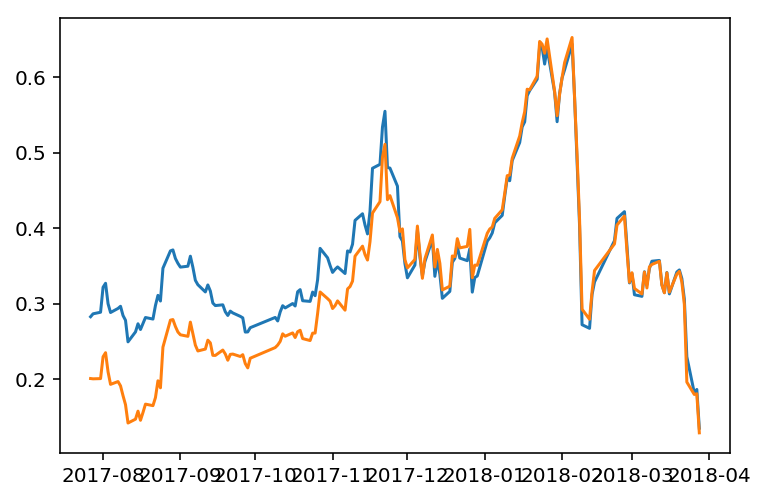

In [7]:
plt.plot(construct_BS_summary_table(['1803', '2.553'])[['bs_simulate','real_price']])

In [8]:
summary = construct_BS_summary_table(['1803', '2.553'])

('Mean_Absolute_Percentage_Error: ', 12.09084406966789)


In [9]:
summary['bs_div_0.2'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'], q=0.2)
summary['bs_div_0.05'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'], q=0.05)
summary

('q=', 0.2)
('q=', 0.2)
('q=', 0.2)
('q=', 0.05)
('q=', 0.05)
('q=', 0.05)


,s,t,r,sigma,bs_simulate,real_price,bs_div_0.2,bs_div_0.05
trade_date,,,,,,,,
2017-07-27,2.677,0.668493,0.042971,0.198123,0.282635,0.2008,0.227303,0.279295
2017-07-28,2.680,0.665753,0.042956,0.201142,0.286513,0.2004,0.232245,0.283243
2017-07-31,2.682,0.657534,0.042945,0.204062,0.288591,0.2007,0.235991,0.285428
2017-08-01,2.724,0.654795,0.042993,0.208366,0.321678,0.2296,0.269978,0.318675
2017-08-02,2.728,0.652055,0.043022,0.212201,0.326899,0.2350,0.276402,0.323969
2017-08-03,2.689,0.649315,0.043042,0.214538,0.299906,0.2097,0.250609,0.296950
2017-08-04,2.671,0.646575,0.043039,0.216481,0.288211,0.1931,0.239914,0.285273
2017-08-07,2.679,0.638356,0.043040,0.218414,0.293633,0.1968,0.246508,0.290784
2017-08-08,2.682,0.635616,0.043031,0.220147,0.296474,0.1911,0.249962,0.293669


In [10]:
summary['s'].mean()

2.8538841463414624

In [11]:
0.05 / summary['s'].mean()

0.017519982394554285

<Figure size 1080x576 with 0 Axes>

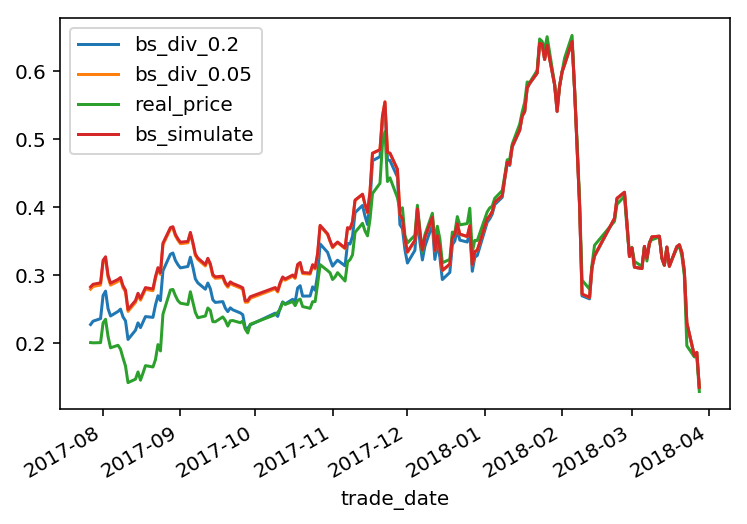

In [12]:
plt.figure(figsize=(15,8))
summary[['bs_div_0.2', 'bs_div_0.05', 'real_price', 'bs_simulate']].plot()
plt.legend()

In [24]:
summary = construct_BS_summary_table(['1709', '2.30'])

('Mean_Absolute_Percentage_Error: ', 5.583340070952623)


In [27]:
summary['bs_div_0.2'] = BlackScholes('C', summary['s'], k, summary['r'], summary['sigma'], summary['t'], q=0.2)

('q=', 0.2)
('q=', 0.2)
('q=', 0.2)


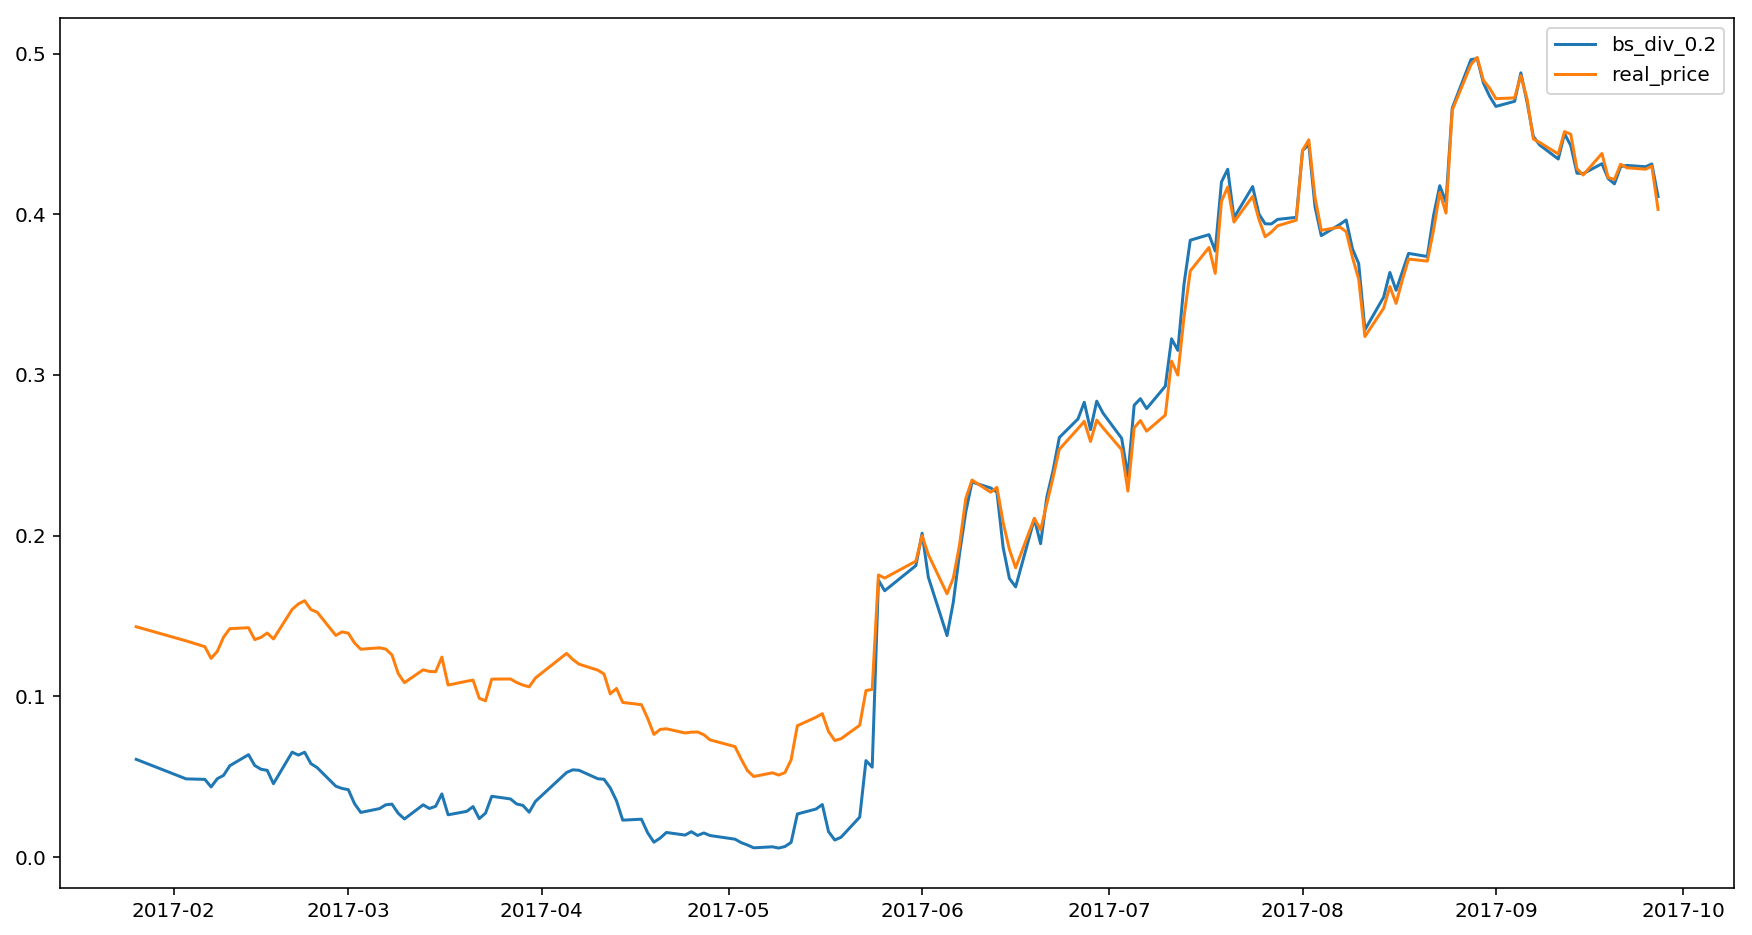

In [28]:
plt.figure(figsize=(15,8))
plt.plot(summary['bs_div_0.2'],label = 'bs_div_0.2')
plt.plot(summary['real_price'],label = 'real_price')

plt.legend()

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(summary['bs_simulate'],label = 'bs_div_0')
plt.plot(summary['bs_div_0.2'],label = 'bs_div_0.05')
plt.plot(summary['real_price'],label = 'real_price')

plt.legend()

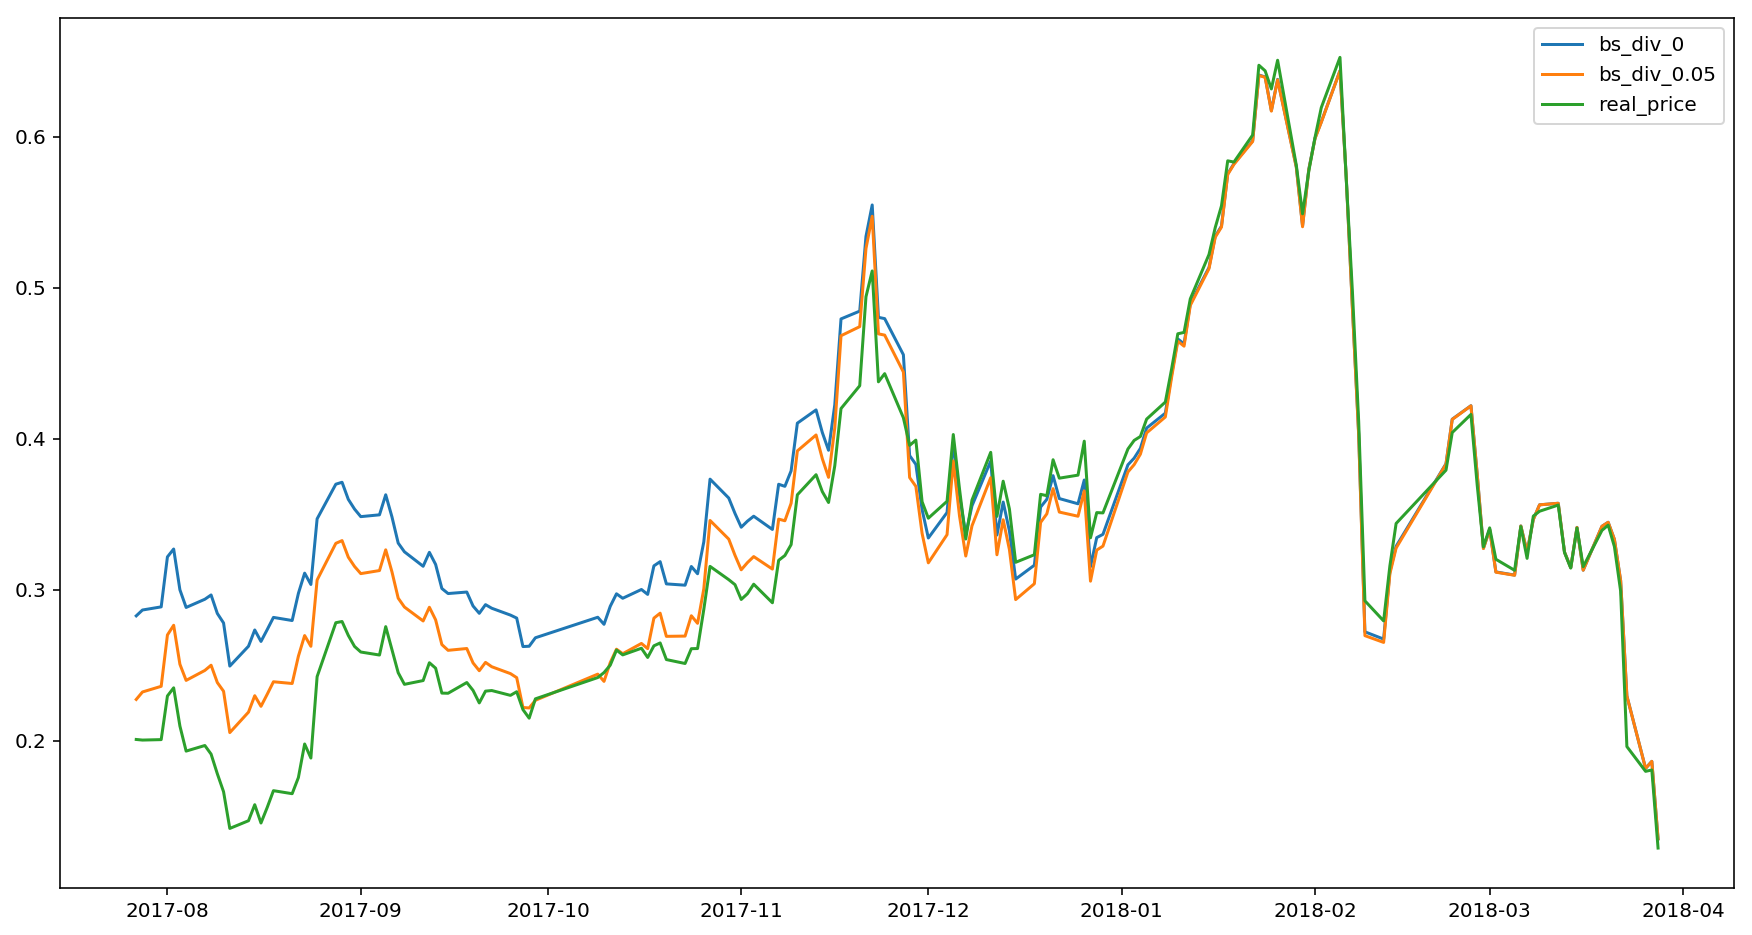

In [14]:
plt.figure(figsize=(15,8))
plt.plot(summary['bs_simulate'],label = 'bs_div_0')
plt.plot(summary['bs_div_0.2'],label = 'bs_div_0.05')
plt.plot(summary['real_price'],label = 'real_price')

plt.legend()

In [15]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Text(0.5,1,'ETF50')

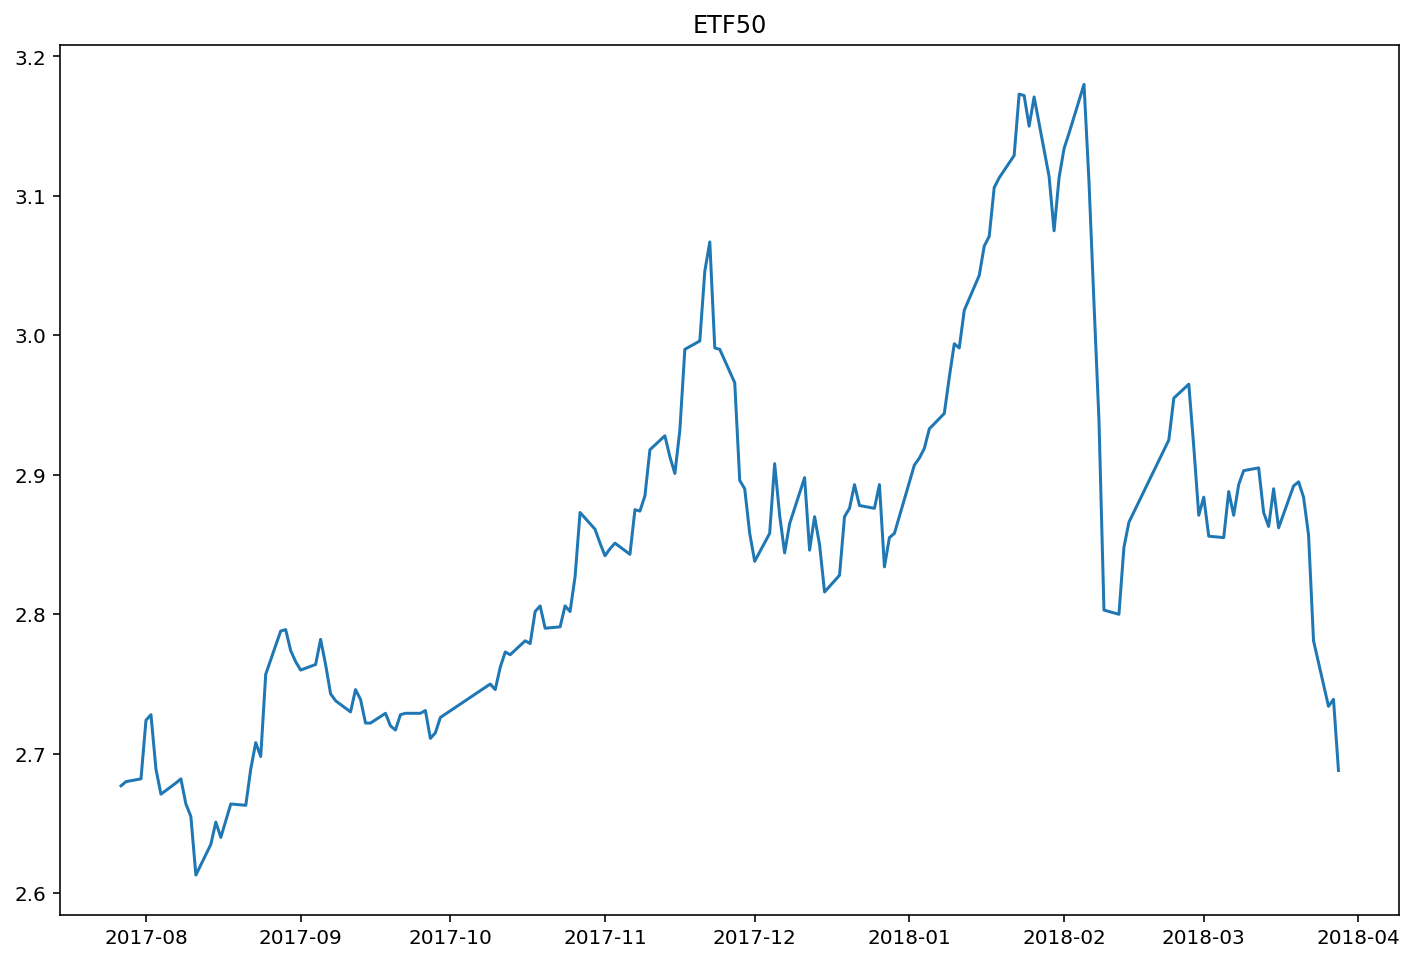

In [16]:
plt.figure(figsize=(12,8))
plt.plot(summary['s'])
plt.title('ETF50')

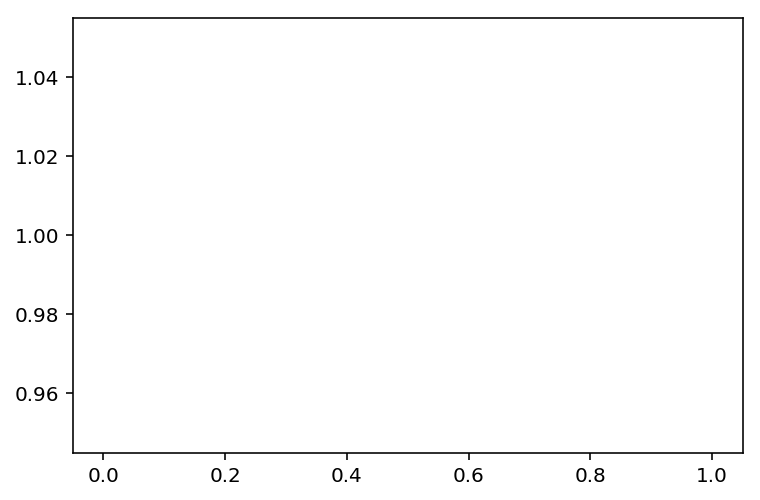

In [17]:
plt.plot(1,1,1,)

(-0.79, 7.789999999999999, 0.0, 4.2)

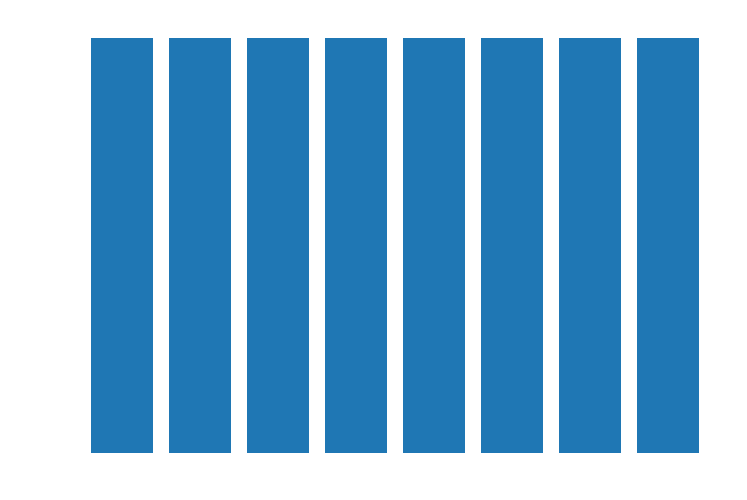

In [18]:
x = [4] * 8
num_list = [1.5,0.6,7.8,6]
plt.bar(range(len(x)), x)
plt.axis('off')

In [19]:
x = [4] * 7


In [20]:
x.append(1)
x

[4, 4, 4, 4, 4, 4, 4, 1]

(-0.79, 7.789999999999999, 0.0, 4.2)

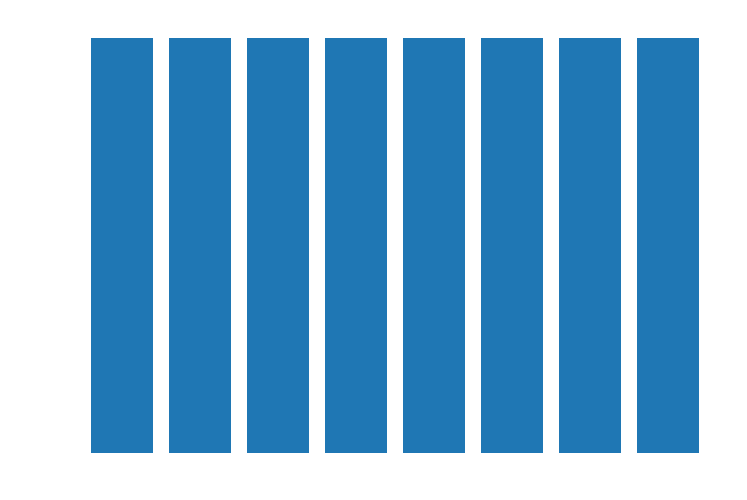

In [21]:
x = [4] * 8
#x.append(8)
    
plt.bar(range(len(x)), x)
plt.axis('off')

(-0.79, 7.789999999999999, 0.0, 11.068417919999995)

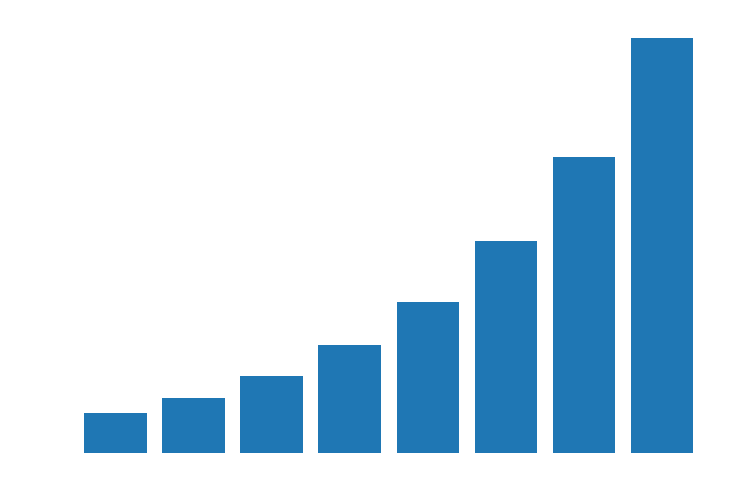

In [22]:
e = np.e

y = [1] * 8
for i in range(8):
    y[i] = 1.4**i

plt.bar(range(len(x)), y)
plt.axis('off')

In [23]:
e

2.718281828459045